### 画像をさらにオーグメンテーション(各1000枚)

In [1]:
import os
import sys
from xml.etree import ElementTree
from xml.etree.ElementTree import Element, SubElement
from lxml import etree
import codecs
import cv2
from glob import glob
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


XML_EXT = '.xml'
ENCODE_METHOD = 'utf-8'

class PascalVocReader:
    '''
    xml形式→yolov3用のtxt形式に変換するクラス
    '''
    def __init__(self, filepath):
        # shapes type:
        # [labbel, [(x1,y1), (x2,y2), (x3,y3), (x4,y4)], color, color, difficult]
        self.shapes = []
        self.filepath = filepath
        self.verified = False
        try:
            self.parseXML()
        except:
            pass

        
    def getShapes(self):
        return self.shapes

    
    def addShape(self, label, bndbox, filename, difficult):
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
                
        points = [xmin,ymin,xmax,ymax]
        self.shapes.append((label, points, filename, difficult))

    def parseXML(self):
        assert self.filepath.endswith(XML_EXT), "Unsupport file format"
        parser = etree.XMLParser(encoding=ENCODE_METHOD)
        xmltree = ElementTree.parse(self.filepath, parser=parser).getroot()
        filename = xmltree.find('filename').text
        path = xmltree.find('path').text
        try:
            verified = xmltree.attrib['verified']
            if verified == 'yes':
                self.verified = True
        except KeyError:
            self.verified = False

        for object_iter in xmltree.findall('object'):
            bndbox = object_iter.find("bndbox")
            label = object_iter.find('name').text
            # Add chris

            difficult = False
            if object_iter.find('difficult') is not None:
                difficult = bool(int(object_iter.find('difficult').text))
            self.addShape(label, bndbox, path, difficult)
        return True


classes = dict()
num_classes = 0

try:
    input = raw_input
except NameError:
    pass

parentpath = './keras-yolo3/blood_cells/' #"Directory path with parent dir before xml_dir or img_dir"
addxmlpath = parentpath + 'annotation' #"Directory path with XML files"
addimgpath = parentpath + 'train' #"Directory path with IMG files"
outputpath = parentpath + 'test_yolo' #"output folder for yolo format"
classes_txt = parentpath + 'classes.txt' #"File containing classes"
ext = '.jpg' #"Image file extension [.jpg or .png]"

num = 0

if os.path.isfile(classes_txt):
    with open(classes_txt, "r") as f:
        class_list = f.read().strip().split()
        classes = {k : v for (v, k) in enumerate(class_list)}

xmlPaths = glob(addxmlpath + "/*.xml")

for xmlPath in xmlPaths:
    tVocParseReader = PascalVocReader(xmlPath)
    shapes = tVocParseReader.getShapes()
    
    with open(parentpath + "annotation.txt", "a") as f:
        
        for shape in shapes:
            class_name = shape[0]
            box = shape[1]
            imgname = './keras-yolo3/blood_cells/train' + xmlPath[36:-4] + ext

            if class_name not in classes.keys():
                classes[class_name] = num_classes
                num_classes += 1
            class_idx = classes[class_name]
            
            #画像読み込み
            image = cv2.imread(imgname)
            
            #サイズ取得
            height, width, channels = image.shape
            
            #resize
            image = cv2.resize(image, (320, 320))
            
            #bounding boxを再計算
            x1 = int(box[0] / width * 320)
            y1 = int(box[1] / height * 320)
            x2 = int(box[2] / width * 320)
            y2 = int(box[3] / height * 320)
            
            bbs = BoundingBoxesOnImage([BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2)], shape=image.shape)
            
            seq = iaa.SomeOf(2, [iaa.GaussianBlur(sigma=(0.0, 1.0)),
                                             iaa.ContrastNormalization((1, 1.5), per_channel=0.7),
                                             iaa.Dropout(p=(0, 0.03))])
            
            # Augment BBs and images.
            image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
    
            after = bbs_aug.bounding_boxes[0]
            
            #書き込み先のpath
            imgnamev2 = './keras-yolo3/blood_cells/trainv2' + xmlPath[36:-4] + ext
            filename = './keras-yolo3/blood_cells/trainv2' + xmlPath[36:-4] + '_' + str(num) + ext
            
            #書き込み
            f.write("%s %d,%d,%d,%d,%d\n" % ('./blood_cells/trainv2' + xmlPath[36:-4] + ext, x1, y1, x2, y2, class_idx))
            f.write("%s %d,%d,%d,%d,%d\n" % ('./blood_cells/trainv2' + xmlPath[36:-4] + '_' + str(num) + ext, x1, y1, x2, y2, class_idx))
            cv2.imwrite(imgnamev2, image)
            cv2.imwrite(filename, image_aug)
            
            #M2Det用にxmlファイルも書き換え
            # xmlファイルの読み込み
            tree = ElementTree.parse(xmlPath)

            for object_iter in tree.findall('object'):
                bndbox = object_iter.find("bndbox")

            # 特定のタグの値を変更
            new_xmin = bndbox.find('xmin')
            new_ymin = bndbox.find('ymin')
            new_xmax = bndbox.find('xmax')
            new_ymax = bndbox.find('ymax')
            new_folder = tree.find('folder')
            new_path = tree.find('path')
            
            #書き換え
            new_xmin.text = str(x1)
            new_ymin.text = str(y1)
            new_xmax.text = str(x2)
            new_ymax.text = str(y2)
            new_folder.text = 'trainv2'
            new_path.text = './data/trainv2' + xmlPath[36:-4] + ext

            #上書き保存
            tree.write(xmlPath, 'utf-8', True)
            
            #新規分書き換え
            new_filename = tree.find('filename')
            new_filename.text = xmlPath[37:-4] + ext
            new_path.text = './data/trainv2' + xmlPath[36:-4] + '_' + str(num) + ext
            
            #保存
            tree.write(xmlPath[:-4] + '_' + str(num) + '.xml', 'utf-8', True)
            
            num += 1
            
                
with open(parentpath + "classes.txt", "w") as f:
    for key in classes.keys():
        f.write("%s\n" % key)

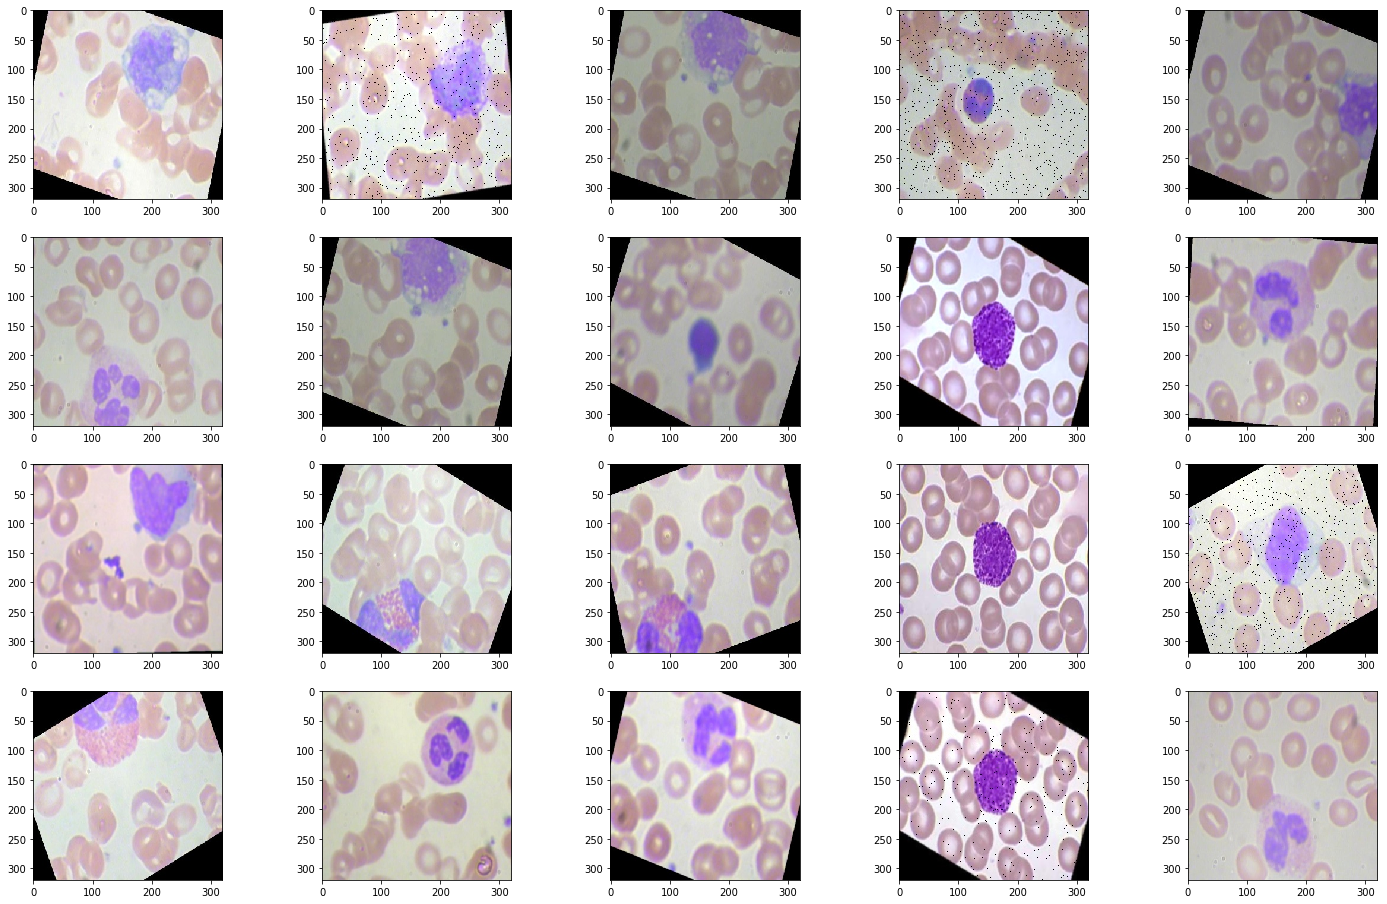

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

columns=5
rows=4

fig = plt.figure(figsize=(5*columns, 4*rows))

for i in range(columns*rows):
    path = np.random.choice(os.listdir('./keras-yolo3/blood_cells/trainv2'))
    img = cv2.imread('./keras-yolo3/blood_cells/trainv2/' + path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)